In [1]:
# Change this to the root directory of the project
%cd /home/hjh/rs-paint

/home/hjh/rs-paint


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
import sys
import glob
from PIL import Image
from tqdm import tqdm
import shutil
import cv2
import math
import random
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from imwatermark import WatermarkEncoder
from itertools import islice
from einops import rearrange
from torchvision import transforms
import torchvision.models as models
from torchvision.utils import make_grid
import time
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import contextmanager, nullcontext
import torchvision
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
import torch.nn.functional as F
from transformers import AutoFeatureExtractor, AutoTokenizer
from torchvision.transforms import Resize

/home/hjh/miniconda3/envs/rspaint/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

def get_tensor(normalize=True, toTensor=True):
    transform_list = []
    if toTensor:
        transform_list += [torchvision.transforms.ToTensor()]

    if normalize:
        transform_list += [torchvision.transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))]
    return torchvision.transforms.Compose(transform_list)

def get_tensor_clip(normalize=True, toTensor=True):
    transform_list = []
    if toTensor:
        transform_list += [torchvision.transforms.ToTensor()]

    if normalize:
        transform_list += [torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                                                (0.26862954, 0.26130258, 0.27577711))]
    return torchvision.transforms.Compose(transform_list)

In [4]:
@torch.inference_mode()
def generate_samples(model, sampler, img_path, mask_path, ref_path, scale, ddim_steps, n_samples, device):
    with model.ema_scope():
        # img input
        img_p = Image.open(img_path).convert('RGB')
        ori_w, ori_h = img_p.size
        img_p = img_p.resize((512, 512))
        image_tensor = get_tensor()(img_p)
        image_tensor = image_tensor.unsqueeze(0).repeat(n_samples, 1, 1, 1)
        image_tensor = image_tensor.to(device)

        # ref img input
        ref_p = Image.open(ref_path).convert('RGB').resize((224,224))
        ref_tensor=get_tensor_clip()(ref_p)
        ref_tensor = ref_tensor.unsqueeze(0).repeat(n_samples, 1, 1, 1)
        ref_tensor = ref_tensor.to(device)

        # mask input
        mask=Image.open(mask_path).convert('L').resize((512, 512), Image.NEAREST)
        mask = np.array(mask)[None,None]
        mask = 1 - mask.astype(np.float32) / 255.0
        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1
        mask_tensor = torch.from_numpy(mask)
        mask_tensor = mask_tensor.repeat(n_samples, 1, 1, 1)
        mask_tensor = mask_tensor.to(device)

        # conditioning
        uc = None
        if scale != 1.0:
            uc = model.learnable_vector
            uc = uc.repeat(n_samples, 1, 1)

        c = model.get_learned_conditioning(ref_tensor)
        c = model.proj_out(c)

        # test args
        test_model_kwargs = {}
        inpaint_image = image_tensor * mask_tensor
        test_model_kwargs['inpaint_mask'] = mask_tensor.to(device)
        test_model_kwargs['inpaint_image'] = inpaint_image.to(device)
        z_inpaint = model.encode_first_stage(test_model_kwargs['inpaint_image'])
        z_inpaint = model.get_first_stage_encoding(z_inpaint).detach()
        test_model_kwargs['inpaint_image'] = z_inpaint
        test_model_kwargs['inpaint_mask'] = Resize([z_inpaint.shape[-2],z_inpaint.shape[-1]])(test_model_kwargs['inpaint_mask'])
        
        # denoising in latent space
        shape = [4, 64, 64]
        samples_ddim, _ = sampler.sample(
            S=ddim_steps,
            conditioning=c,
            batch_size=n_samples,
            shape=shape,
            verbose=False,
            unconditional_guidance_scale=scale,
            unconditional_conditioning=uc,
            eta=0.0,
            x_T=None,
            test_model_kwargs=test_model_kwargs
        )

        # decoding back to pixel space
        x_samples_ddim = model.decode_first_stage(samples_ddim)
        x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
        x_samples_ddim = x_samples_ddim.cpu().permute(0, 2, 3, 1).numpy()

        return x_samples_ddim, ori_w, ori_h


In [20]:
seed = 20250110
device = 0
seed_everything(seed)
config = OmegaConf.load('configs/rs_remoteclip.yaml')
model = load_model_from_config(config, 'checkpoints/sd_inpaint_samrs_ep74.ckpt')
model = model.to(device)
sampler = PLMSSampler(model)

Global seed set to 20250110


Loading model from checkpoints/sd_inpaint_samrs_ep74.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.54 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


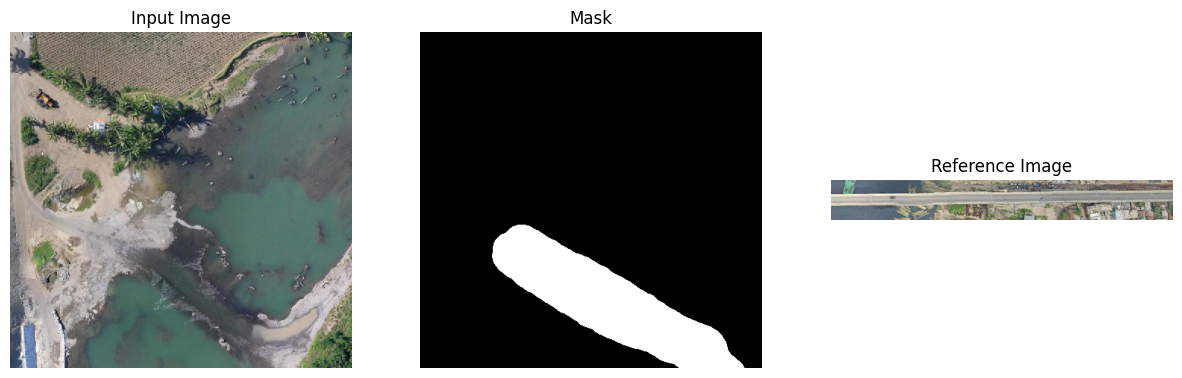

In [33]:
img_path = 'figure/examples/img3.png'
mask_path = 'figure/examples/mask3.png'
ref_path = 'figure/examples/ref3.png'
scale = 8
ddim_steps = 50
n_samples = 4

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(Image.open(img_path))
plt.axis('off')
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(Image.open(mask_path), cmap='gray')
plt.axis('off')
plt.title('Mask')

plt.subplot(1, 3, 3)
plt.imshow(Image.open(ref_path))
plt.axis('off')
plt.title('Reference Image')

plt.show()

In [34]:
samples, ori_w, ori_h = generate_samples(model, sampler, img_path, mask_path, ref_path, scale, ddim_steps, n_samples, device)

Data shape for PLMS sampling is (4, 4, 64, 64)
Running PLMS Sampling with 50 timesteps


PLMS Sampler: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.67it/s]


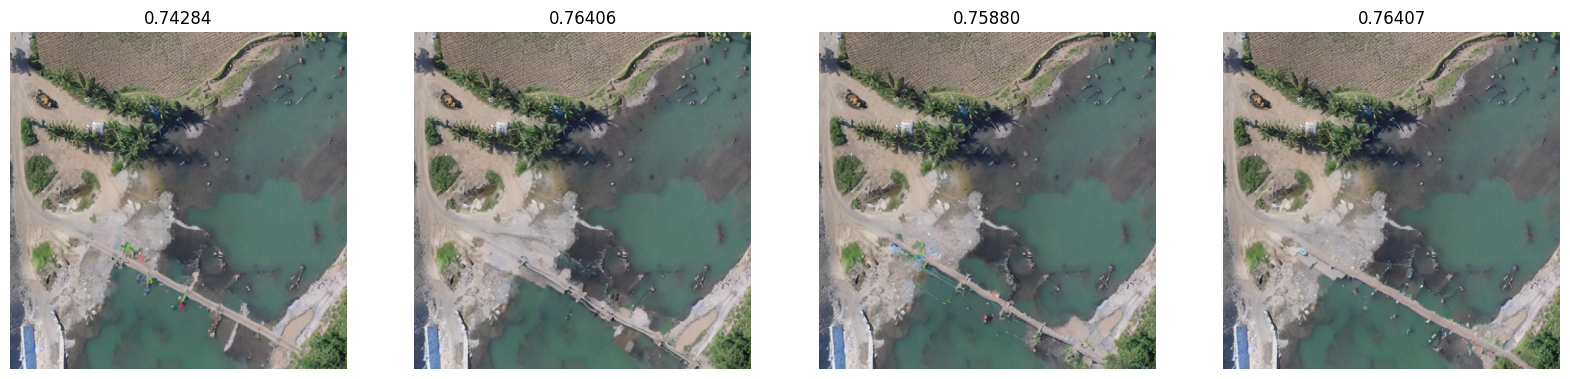

In [35]:
img_preprocessor = model.cond_stage_model.preprocess
ref_img = Image.open(ref_path)
ref_img = img_preprocessor(ref_img)
ref_feat = model.cond_stage_model.get_visual_clip_features(ref_img.unsqueeze(0).to(device))

plt.figure(figsize=(20, 20))
for i in range(n_samples):
    result = (samples[i] * 255).astype(np.uint8)
    result = Image.fromarray(result)
    result_tensor = img_preprocessor(result).unsqueeze(0).to(device)
    result_feat = model.cond_stage_model.get_visual_clip_features(result_tensor)
    similarity = F.cosine_similarity(ref_feat, result_feat, dim=-1)
    plt.subplot(1, n_samples, i + 1)
    plt.imshow(result)
    plt.axis('off')
    plt.title(f'{similarity.item():.5f}')

plt.show()